In [21]:
import os
import pickle
import numpy as np
import xgboost as xgb
import pandas as pd

n_bootstrap = 100

ft_dir = 'features_long/'

# list feature files
files = os.listdir(ft_dir)

with open('top_locations.dat') as f:
    state_top10 = pickle.load(f)
f.close()
for (i,s) in enumerate(state_top10):
    state_top10[i] = state_top10[i].replace('"','')
    state_top10[i] = state_top10[i].replace('[','')
    state_top10[i] = state_top10[i].replace(']','')

feature_all = []
state_all = []
state_fsq_all = []
for filename in files:
    with open(ft_dir+filename) as f:  
        feature, state = pickle.load(f)
        
        # only keeping top 10 states
        ind = np.array([], int)
        for (i,st) in enumerate(state['location']):
            if st in state_top10:
                ind = np.append(ind, i)
        feature = feature.loc[ind,:]
        state = state.loc[ind,'location']
        
        feature = feature.reset_index(drop = True)
        state = state.reset_index(drop = True)
        
        feature_all.append(feature)
        state_all.append(state)
        
    f.close()

inds = np.arange(0,len(feature_all),1)
inds_split = np.floor(0.7*len(feature_all))
    
gbm = [[] for _ in range(n_bootstrap)]
for sd in range(n_bootstrap):
    print 'bootstrap {}'.format(sd)
#     np.random.shuffle(inds)
#     ind_train = inds[:inds_split]
#     x_train = pd.concat([feature_all[j] for j in ind_train], axis=0)
#     y_train = pd.concat([state_all[j] for j in ind_train], axis=0)

    x_train = pd.DataFrame(columns=feature_all[0].columns)
    y_train = pd.Series(name=state_all[0].name)
    for i in range(len(feature_all)):
        ind = np.random.choice(np.arange(feature_all[i].shape[0]),size=1)
        x_train = pd.concat([x_train, feature_all[i].loc[ind,:]], axis=0)
        y_train = pd.concat([y_train, state_all[i].loc[ind]], axis=0)
        x_train = x_train.reset_index(drop = True)
        y_train = y_train.reset_index(drop = True)

    gbm[sd] = xgb.XGBClassifier(max_depth=6, n_estimators=75, learning_rate=0.05, nthread=12, subsample=0.25, \
                        colsample_bytree=0.2, max_delta_step=0, gamma=3, objective='mlogloss', reg_alpha=0.5, \
                        missing=np.nan).fit(x_train, y_train)


bootstrap 0
bootstrap 1
bootstrap 2
bootstrap 3
bootstrap 4
bootstrap 5
bootstrap 6
bootstrap 7
bootstrap 8
bootstrap 9
bootstrap 10
bootstrap 11
bootstrap 12
bootstrap 13
bootstrap 14
bootstrap 15
bootstrap 16
bootstrap 17
bootstrap 18
bootstrap 19
bootstrap 20
bootstrap 21
bootstrap 22
bootstrap 23
bootstrap 24
bootstrap 25
bootstrap 26
bootstrap 27
bootstrap 28
bootstrap 29
bootstrap 30
bootstrap 31
bootstrap 32
bootstrap 33
bootstrap 34
bootstrap 35
bootstrap 36
bootstrap 37
bootstrap 38
bootstrap 39
bootstrap 40
bootstrap 41
bootstrap 42
bootstrap 43
bootstrap 44
bootstrap 45
bootstrap 46
bootstrap 47
bootstrap 48
bootstrap 49
bootstrap 50
bootstrap 51
bootstrap 52
bootstrap 53
bootstrap 54
bootstrap 55
bootstrap 56
bootstrap 57
bootstrap 58
bootstrap 59
bootstrap 60
bootstrap 61
bootstrap 62
bootstrap 63
bootstrap 64
bootstrap 65
bootstrap 66
bootstrap 67
bootstrap 68
bootstrap 69
bootstrap 70
bootstrap 71
bootstrap 72
bootstrap 73
bootstrap 74
bootstrap 75
bootstrap 76
bootstrap

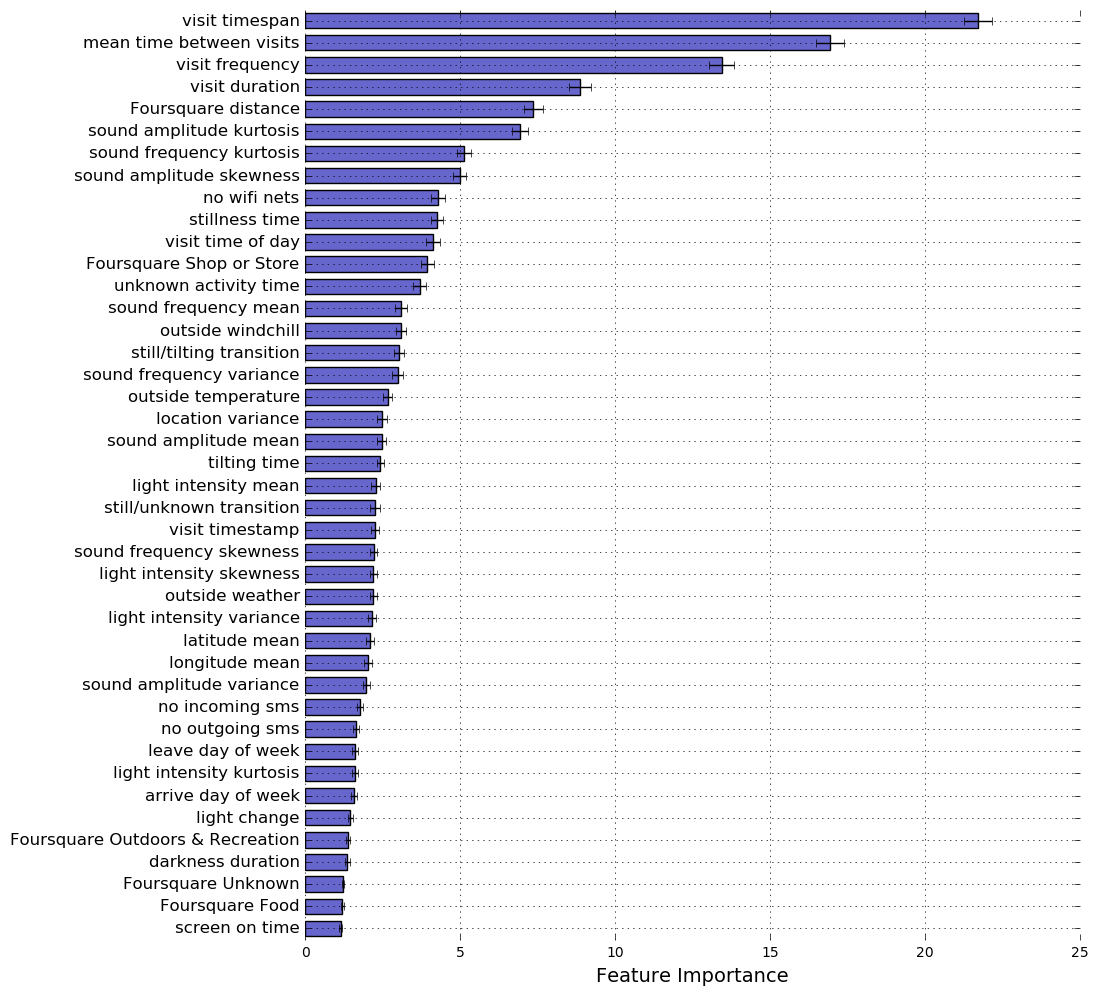

In [42]:
import matplotlib.pyplot as plt
import numpy as np

dic = {'lgt mean':'light intensity mean', 'lgt std':'light intensity variance', 'lgt off':'darkness duration', 'lgt zcrossing':'light change',\
       'lgt skew':'light intensity skewness', 'lgt kurt':'light intensity kurtosis', 'aud mean':'sound amplitude mean', \
       'aud std':'sound amplitude variance', 'aud skew':'sound amplitude skewness', 'aud kurt':'sound amplitude kurtosis',\
       'aud frq mean':'sound frequency mean', 'aud frq std':'sound frequency variance', 'aud frq skew':'sound frequency skewness',\
       'aud frq kurt':'sound frequency kurtosis', 'scr frq':'screen on/off frequency', 'scr dur mean':'screen on time', \
       'scr dur std':'screen on time variance', 'still':'stillness time', 'tilting':'tilting time', 'walking':'walking time',\
       'unknown act':'unknown activity time', 'still-walking':'still/walking transition', 'still-tilting':'still/tilting transition',\
       'still-unknown':'still/unknown transition', 'walking-unknown':'walking/unknown transition', 'call in':'no incoming calls', 'call out':\
       'no outgoing calls', 'sms in':'no incoming sms', 'sms out':'no outgoing sms', 'call missed':'no missed calls', 'n wifi':\
       'no wifi nets', 'temperature':'outside temperature', 'dew point':'outside windchill', 'weather':'outside weather', \
       'lat mean':'latitude mean', 'lng mean':'longitude mean', 'loc var':'location variance', 'duration':'visit timespan',\
       'midtime':'visit timestamp', 'midhour':'visit time of day', 'dow start':'arrive day of week', 'dow end':\
       'leave day of week', 'fsq 0':'Foursquare Nightlife Spot', 'fsq 1':'Foursquare Outdoors & Recreation', 'fsq 2':'Foursquare Arts & Entertainment'\
       , 'fsq 3':'Foursquare Professional or Medical Office', 'fsq 4':'Foursquare Food', 'fsq 5':'Foursquare Home', \
       'fsq 6':'Foursquare Shop or Store', 'fsq 7':'Foursquare Travel or Transport', 'fsq 8':'Foursquare Unknown', 'fsq distance':\
       'Foursquare distance', 'LT frequency':'visit frequency', 'LT interval mean':'mean time between visits', 'n gps':'visit duration'}

# extracting means and CIs
feature_label = x_train.columns

fscore = pd.DataFrame(index=np.arange(n_bootstrap), columns=feature_label)
for i in range(n_bootstrap):
    keys = np.array(gbm[i].booster().get_fscore().keys())
    vals = np.array(gbm[i].booster().get_fscore().values()).astype(float)
    for lab in feature_label:
        ind = np.where(keys==lab)[0]
        if ind.size>0:
            fscore.loc[i,lab] = vals[ind[0]]
fscore_mean = np.array(fscore.mean(axis=0))
fscore_ci = np.array(fscore.std(axis=0)/np.sqrt(n_bootstrap))
ind_sort = np.array(np.argsort(fscore_mean))
val_sorted = fscore_mean[ind_sort]
ci_sorted = fscore_ci[ind_sort]
feature_label_sorted = feature_label[ind_sort]
feature_label_short = []
for i in range(feature_label_sorted.size):
    feature_label_short.append(dic[feature_label_sorted[i]])
    
%matplotlib inline
plt.figure(figsize=(10,12))
axes = plt.gca()
plt.barh(np.arange(val_sorted.size), val_sorted, xerr=ci_sorted, height=.7, color=(.4,.4,.8), align='center', ecolor=(0,0,0))
plt.yticks(np.arange(len(feature_label_short)), feature_label_short, fontsize=12, color=(0,0,0));
axes.set_ylim([3.5, len(feature_label_short)-9.5])
plt.box(on=False)
plt.xlabel('Feature Importance',fontsize=14)
plt.grid()

In [18]:
feature_all[0].columns

Index([u'lgt mean', u'lgt std', u'lgt off', u'lgt zcrossing', u'lgt skew',
       u'lgt kurt', u'aud mean', u'aud std', u'aud skew', u'aud kurt',
       u'aud frq mean', u'aud frq std', u'aud frq skew', u'aud frq kurt',
       u'scr frq', u'scr dur mean', u'scr dur std', u'still', u'tilting',
       u'walking', u'unknown act', u'still-walking', u'still-tilting',
       u'still-unknown', u'walking-unknown', u'call in', u'call out',
       u'sms in', u'sms out', u'call missed', u'n wifi', u'temperature',
       u'dew point', u'weather', u'lat mean', u'lng mean', u'loc var',
       u'duration', u'midtime', u'midhour', u'dow start', u'dow end', u'n gps',
       u'fsq 0', u'fsq 1', u'fsq 2', u'fsq 3', u'fsq 4', u'fsq 5', u'fsq 6',
       u'fsq 7', u'fsq 8', u'fsq distance', u'LT frequency',
       u'LT interval mean'],
      dtype='object')